In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/label_encoded_telecom_data.csv')

In [3]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the specified columns
df[['TotalCharges', 'MonthlyCharges', 'tenure']] = scaler.fit_transform(df[['TotalCharges', 'MonthlyCharges', 'tenure']])

# Display the first few rows to verify the scaling
print(df[['TotalCharges', 'MonthlyCharges', 'tenure']].head())

   TotalCharges  MonthlyCharges    tenure
0     -0.994194       -1.161694 -1.280248
1     -0.173740       -0.260878  0.064303
2     -0.959649       -0.363923 -1.239504
3     -0.195248       -0.747850  0.512486
4     -0.940457        0.196178 -1.239504


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Split the data into training and testing sets
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine X_train and y_train for resampling
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data.Churn == 0]
minority_class = train_data[train_data.Churn == 1]

# Downsample majority class
majority_downsampled = resample(majority_class, 
                                replace=False,    # sample without replacement
                                n_samples=len(minority_class), # to match minority class
                                random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_train_data = pd.concat([majority_downsampled, minority_class])

# Separate features and target variable
X_train_downsampled = downsampled_train_data.drop('Churn', axis=1)
y_train_downsampled = downsampled_train_data['Churn']

In [58]:
X_train_downsampled = X_train_downsampled.drop('customerID', axis=1)

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, recall_score, classification_report

f1_scorer = make_scorer(f1_score, average='binary')
weighted_f1_scorer = make_scorer(f1_score, average='weighted')
recall_scorer = make_scorer(recall_score, average='binary')


In [60]:
from sklearn.tree import DecisionTreeClassifier


# Define the parameter grid
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 7, 10, 12],
    'min_samples_split': [2, 5, 10],
    'max_features': [1, 2, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

scorers = [f1_scorer, weighted_f1_scorer, recall_scorer]

for scorer in scorers:
    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid_dt, scoring=scorer, cv=5, n_jobs=-1)

    # Fit the grid search to the data
    grid_search.fit(X_train_downsampled, y_train_downsampled)

    # Get the best estimator
    best_dt = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_dt.predict(X_test.drop('customerID', axis=1))


    print(f"Scorer: {scorer}")
    print(f"Best parameters found: {grid_search.best_params_}")
    print("Classification report on train set")
    print(classification_report(y_train_downsampled, best_dt.predict(X_train_downsampled)))
    print(f"Classification report on test set")
    print(classification_report(y_test, y_pred))


Scorer: make_scorer(f1_score, average=binary)
Best parameters found: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Classification report on train set
              precision    recall  f1-score   support

           0       0.79      0.67      0.72      1495
           1       0.71      0.82      0.76      1495

    accuracy                           0.74      2990
   macro avg       0.75      0.74      0.74      2990
weighted avg       0.75      0.74      0.74      2990

Classification report on test set
              precision    recall  f1-score   support

           0       0.91      0.66      0.76      1033
           1       0.46      0.81      0.59       374

    accuracy                           0.70      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.79      0.70      0.72      1407

Scorer: make_scorer(f1_score, average=weighted)
Best parameters found: {'criterio

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 51, 100, 101],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 7],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

for scorer in scorers:

    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring=scorer, cv=5, n_jobs=-1)
    grid_search_rf.fit(X_train_downsampled, y_train_downsampled)
    best_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test.drop('customerID', axis=1))
    
    print(f"Scorer: {scorer}")
    print(f"Best parameters found: {grid_search_rf.best_params_}")
    print("Classification report on train set")
    print(classification_report(y_train_downsampled, best_rf.predict(X_train_downsampled)))
    print(f"Classification report on test set")
    print(classification_report(y_test, y_pred_rf))

Scorer: make_scorer(f1_score, average=binary)
Best parameters found: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Classification report on train set
              precision    recall  f1-score   support

           0       0.81      0.73      0.76      1495
           1       0.75      0.82      0.79      1495

    accuracy                           0.78      2990
   macro avg       0.78      0.78      0.78      2990
weighted avg       0.78      0.78      0.78      2990

Classification report on test set
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1033
           1       0.49      0.81      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.72      0.74      1407

Scorer: make_scorer(f1_score, average=weighted)
Best parame

In [84]:
from sklearn.svm import SVC

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 0.01],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [1, 2]
}

# Initialize the SVM classifier
svm = SVC(random_state=42)

for scorer in scorers:

    grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, scoring=scorer, cv=5, n_jobs=-1)

    grid_search_svm.fit(X_train_downsampled, y_train_downsampled)

    best_svm = grid_search_svm.best_estimator_

    y_pred_svm = best_svm.predict(X_test.drop('customerID', axis=1))

    print(f"Scorer: {scorer}")
    print(f"Best parameters found: {grid_search_svm.best_params_}")
    print("Classification report on train set")
    print(classification_report(y_train_downsampled, best_svm.predict(X_train_downsampled)))
    print(f"Classification report on test set")
    print(classification_report(y_test, y_pred_svm))


Scorer: make_scorer(f1_score, average=binary)
Best parameters found: {'C': 0.1, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}
Classification report on train set
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1495
           1       0.72      0.83      0.77      1495

    accuracy                           0.75      2990
   macro avg       0.76      0.75      0.75      2990
weighted avg       0.76      0.75      0.75      2990

Classification report on test set
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1033
           1       0.47      0.82      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.68      1407
weighted avg       0.79      0.71      0.72      1407

Scorer: make_scorer(f1_score, average=weighted)
Best parameters found: {'C': 0.1, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}
Classification report on 

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42)

for scorer in scorers:
    grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, scoring=scorer, cv=5, n_jobs=-1)
    grid_search_xgb.fit(X_train_downsampled, y_train_downsampled)

    best_xgb = grid_search_xgb.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test.drop('customerID', axis=1))

    print(f"Scorer: {scorer}")
    print(f"Best parameters found: {grid_search_xgb.best_params_}")
    print("Classification report on train set")
    print(classification_report(y_train_downsampled, best_xgb.predict(X_train_downsampled)))
    print(f"Classification report on test set")
    print(classification_report(y_test, y_pred_xgb))

Scorer: make_scorer(f1_score, average=binary)
Best parameters found: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Classification report on train set
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1495
           1       0.79      0.86      0.82      1495

    accuracy                           0.82      2990
   macro avg       0.82      0.82      0.82      2990
weighted avg       0.82      0.82      0.82      2990

Classification report on test set
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407

Scorer: make_scorer(f1_score, average=weighted)
Best parameters found: {'colsample_bytree': 

In [12]:
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
classifier_xgb.fit(X_train_downsampled, y_train_downsampled)
print(f"Best train score found for XGBoost: {classifier_xgb.score(X_train_downsampled, y_train_downsampled)}")
print(f"Best test score found for XGBoost: {classifier_xgb.score(X_test.drop('customerID', axis=1), y_test)}")

Best train score found for XGBoost: 0.7926421404682275
Best test score found for XGBoost: 0.7185501066098081


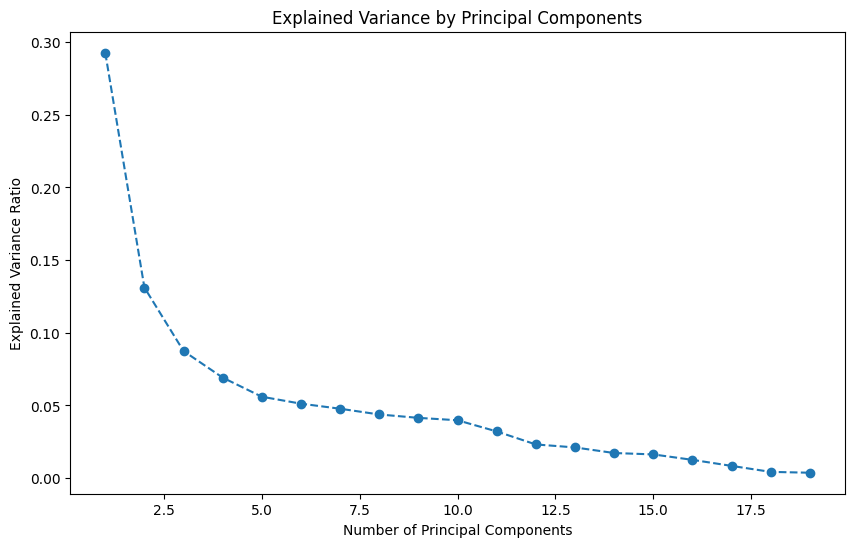

In [23]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Initialize PCA
pca = PCA()

# Fit PCA on the training data
pca.fit(X_train_downsampled)

# Plot the explained variances
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

/home/prajas/anaconda3/envs/cuda_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/prajas/anaconda3/envs/cuda_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/prajas/anaconda3/envs/cuda_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/prajas/anaconda3/envs/cuda_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureW

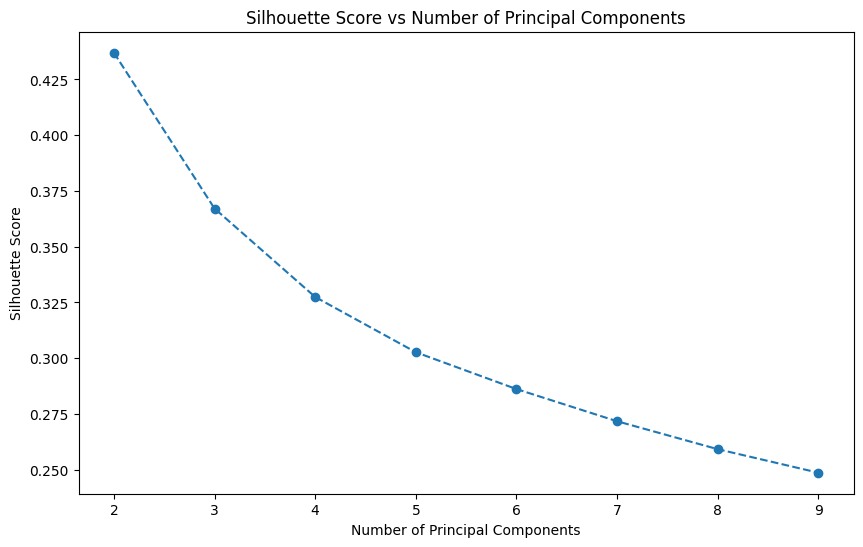

In [24]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Initialize lists to store the number of components and corresponding silhouette scores
n_components_list = list(range(2, 10))
silhouette_scores = []

# Loop over the range of components
for n_components in n_components_list:
    # Initialize PCA with the current number of components
    pca = PCA(n_components=n_components)
    
    # Fit and transform the training data
    X_train_pca = pca.fit_transform(X_train_downsampled)
    
    # Perform KMeans clustering with 2 clusters
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_train_pca)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X_train_pca, kmeans_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Silhouette Score')
plt.show()

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Determine the number of components that explain 60% of the variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
k = (cumulative_variance < 0.90).sum() + 1

# Transform the training and test data using the selected number of principal components
X_train_pca = pca.transform(X_train_downsampled)[:, :k]
X_test_pca = pca.transform(X_test.drop('customerID', axis=1))[:, :k]

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 7, 10, 12],
    'min_samples_split': [2, 5, 10],
    'max_features': [1, 2, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object
grid_search_pca = GridSearchCV(estimator=dt, param_grid=param_grid, scoring=weighted_f1_scorer, cv=5, n_jobs=-1)

# Fit the grid search to the PCA-transformed data
grid_search_pca.fit(X_train_pca, y_train_downsampled)

# Get the best estimator
best_dt_pca = grid_search_pca.best_estimator_

# Predict on the test set
y_pred_pca = best_dt_pca.predict(X_test_pca)

# Calculate the F1 score
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')

print(f"Number of principal components: {k}")
print(f"Best parameters found: {grid_search_pca.best_params_}")
print("Classification report on test set")
print(classification_report(y_test, y_pred_pca))
print("Classification report on train set")
print(classification_report(y_train_downsampled, best_dt_pca.predict(X_train_pca)))

Number of principal components: 10
Best parameters found: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Classification report on test set
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1033
           1       0.49      0.75      0.59       374

    accuracy                           0.72      1407
   macro avg       0.69      0.73      0.69      1407
weighted avg       0.78      0.72      0.74      1407

Classification report on train set
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1495
           1       0.78      0.82      0.80      1495

    accuracy                           0.80      2990
   macro avg       0.80      0.80      0.80      2990
weighted avg       0.80      0.80      0.80      2990



In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Initialize the Logistic Regression classifier
lr = LogisticRegression(random_state=42)
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300]
}

for scorer in scorers:
    grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, scoring=scorer, cv=5, n_jobs=-1)
    grid_search_lr.fit(X_train_downsampled, y_train_downsampled)
    best_lr = grid_search_lr.best_estimator_
    y_pred_lr = best_lr.predict(X_test.drop('customerID', axis=1))
    print(f"Scorer: {scorer}")
    print(f"Best parameters found: {grid_search_lr.best_params_}")
    print("Classification report on train set")
    print(classification_report(y_train_downsampled, best_lr.predict(X_train_downsampled)))
    print(f"Classification report on test set")
    print(classification_report(y_test, y_pred_lr))


Scorer: make_scorer(f1_score, average=binary)
Best parameters found: {'C': 100, 'max_iter': 100}
Classification report on train set
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1495
           1       0.75      0.82      0.78      1495

    accuracy                           0.77      2990
   macro avg       0.77      0.77      0.77      2990
weighted avg       0.77      0.77      0.77      2990

Classification report on test set
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407

Scorer: make_scorer(f1_score, average=weighted)
Best parameters found: {'C': 100, 'max_iter': 100}
Classification report on train set
              precision    recall  f1-score   

In [52]:
lr_elastic  = LogisticRegression(random_state=42, penalty='l1', solver='liblinear', C=100)
lr_elastic.fit(X_train_downsampled, y_train_downsampled)
y_pred_lr_elastic = lr_elastic.predict(X_test.drop('customerID', axis=1))

print("Classification report on train set")
print(classification_report(y_train_downsampled, lr_elastic.predict(X_train_downsampled)))
print("Classification report on test set")
print(classification_report(y_test, y_pred_lr_elastic))

Classification report on train set
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1495
           1       0.75      0.82      0.78      1495

    accuracy                           0.77      2990
   macro avg       0.77      0.77      0.77      2990
weighted avg       0.77      0.77      0.77      2990

Classification report on test set
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407



In [61]:
import torch
import torch.nn as nn

class DynamicNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers_config, activation_function=nn.ReLU):
        """
        input_size: int, the size of the input features
        output_size: int, the number of output classes
        hidden_layers_config: list of int, where each int represents the number of neurons in that layer
        activation_function: nn.Module, the activation function class (e.g., nn.ReLU, nn.Tanh)
        """
        super(DynamicNN, self).__init__()
        layers = []

        # Construct the hidden layers with the chosen activation function
        current_size = input_size
        for num_neurons in hidden_layers_config:
            layers.append(nn.Linear(current_size, num_neurons))
            layers.append(activation_function())  # Add the chosen activation function
            current_size = num_neurons

        # Add the final output layer (without activation)
        layers.append(nn.Linear(current_size, output_size))

        # Combine layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [62]:
def GetDevice():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = GetDevice()
print(device)

cuda


In [63]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchModel(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, output_size, hidden_layers_config=[64, 32], activation_function=nn.ReLU, lr=0.001, epochs=10, batch_size=32):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers_config = hidden_layers_config
        self.activation_function = activation_function
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes_ = None
        self.model = DynamicNN(input_size, output_size, hidden_layers_config, activation_function).to(device)
        
    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X).to(device)
        y_tensor = torch.LongTensor(y).to(device)
        
        self.classes_ = torch.unique(y_tensor).cpu().numpy()  
        
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        self.model.train()
        for epoch in range(self.epochs):
            for inputs, targets in dataloader:

                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad() #Setting gradient to zero after every iteration
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        return self

    def score(self, X, y):

        X_tensor = torch.FloatTensor(X).to(device)
        y_tensor = torch.LongTensor(y).to(device)
        self.model.eval()
        with torch.no_grad(): # To ensure gradients are not calculated
            
            outputs = self.model(X_tensor)
            _, predictions = torch.max(outputs, 1)
            accuracy = (predictions == y_tensor).sum().item() / len(y_tensor)
        return accuracy
    
    def predict(self, X):
        X_tensor = torch.FloatTensor(X).to(device)
        self.model.eval()
        with torch.no_grad(): # To ensure gradients are not calculated
            
            outputs = self.model(X_tensor)
            _, predictions = torch.max(outputs, 1)

        return predictions.cpu().numpy()



In [66]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for PyTorchModel
param_grid_pytorch = {
    'hidden_layers_config': [[30, 30], [64, 32], [128, 64, 32], [128, 128, 128]],
    'activation_function': [nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU],
    'lr': [0.001, 0.01],
    'epochs': [10, 20, 30],
    'batch_size': [128, 256, 512]
}

# Initialize the PyTorchModel
pytorch_model = PyTorchModel(input_size=X_train_downsampled.shape[1], output_size=len(y_train_downsampled.unique()))

for scorer in scorers:
    grid_search_pytorch = GridSearchCV(estimator=pytorch_model, param_grid=param_grid_pytorch, scoring=scorer, cv=5, n_jobs=-1)
    X_train_downsampled_np = X_train_downsampled.to_numpy() 
    y_train_downsampled_np = y_train_downsampled.to_numpy()
    grid_search_pytorch.fit(X_train_downsampled_np, y_train_downsampled_np)
    best_pytorch_model = grid_search_pytorch.best_estimator_
    y_pred_pytorch = best_pytorch_model.predict(X_test.drop('customerID', axis=1).to_numpy())
    print(f"Scorer: {scorer}")
    print(f"Best parameters found: {grid_search_pytorch.best_params_}")
    print("Classification report on train set")
    print(classification_report(y_train_downsampled, best_pytorch_model.predict(X_train_downsampled_np)))
    print(f"Classification report on test set")
    print(classification_report(y_test, y_pred_pytorch))


Scorer: make_scorer(f1_score, average=binary)
Best parameters found: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 512, 'epochs': 10, 'hidden_layers_config': [30, 30], 'lr': 0.01}
Classification report on train set
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1495
           1       0.76      0.82      0.79      1495

    accuracy                           0.78      2990
   macro avg       0.78      0.78      0.78      2990
weighted avg       0.78      0.78      0.78      2990

Classification report on test set
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407

Scorer: make_scorer(f1_score, average=weighted)
Best paramete

In [43]:

# Predict on the test set
y_pred_pytorch = best_pytorch_model.predict(X_test.drop(['customerID', 'Cluster'], axis=1).to_numpy())

# Calculate the F1 score
f1_pytorch = f1_score(y_test, y_pred_pytorch)

print(f"Best parameters found for PyTorchModel: {grid_search_pytorch.best_params_}")
print(f"F1 score on test set for PyTorchModel: {f1_pytorch}")
print(f"Best train score found for PyTorchModel: {grid_search_pytorch.best_score_}")

Best parameters found for PyTorchModel: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 128, 'epochs': 10, 'hidden_layers_config': [64, 32], 'lr': 0.001}
F1 score on test set for PyTorchModel: 0.6140155728587319
Best train score found for PyTorchModel: 0.761785955542436


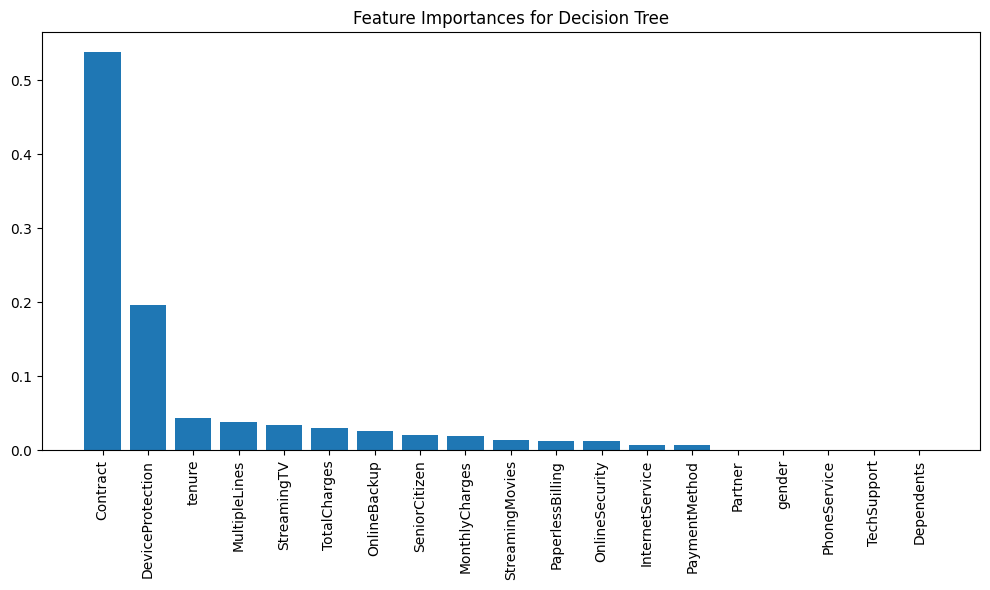

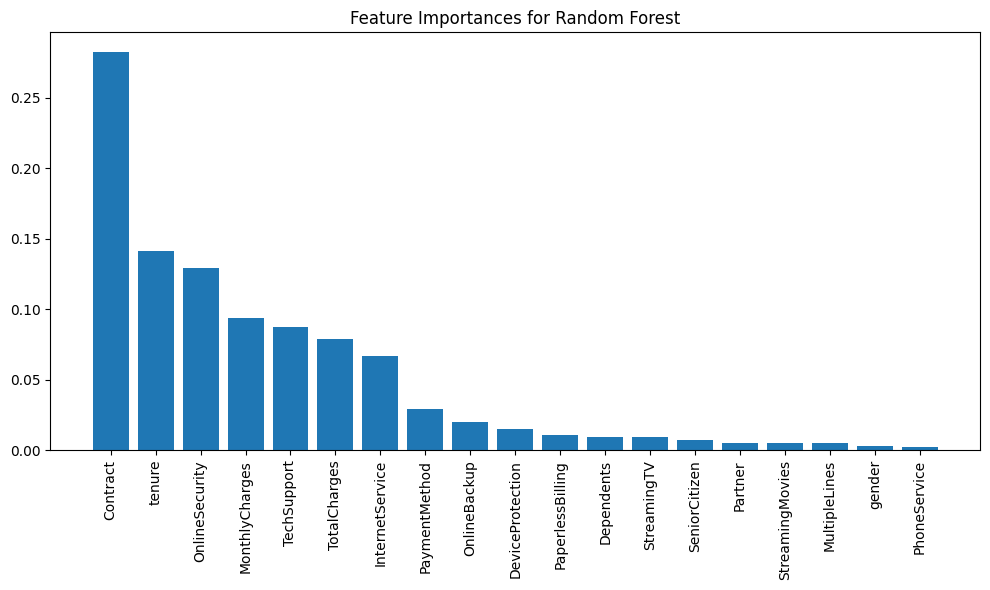

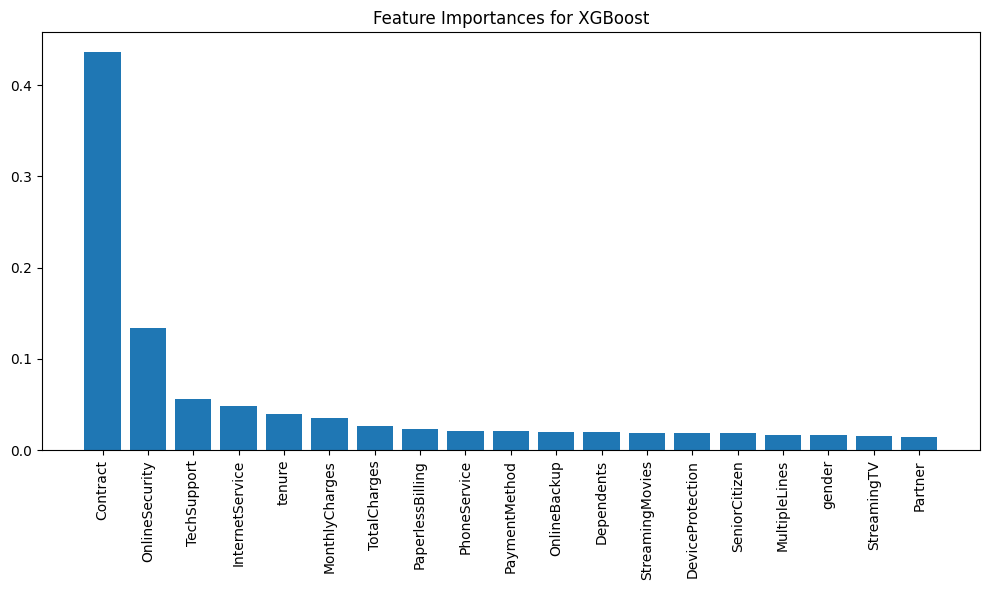

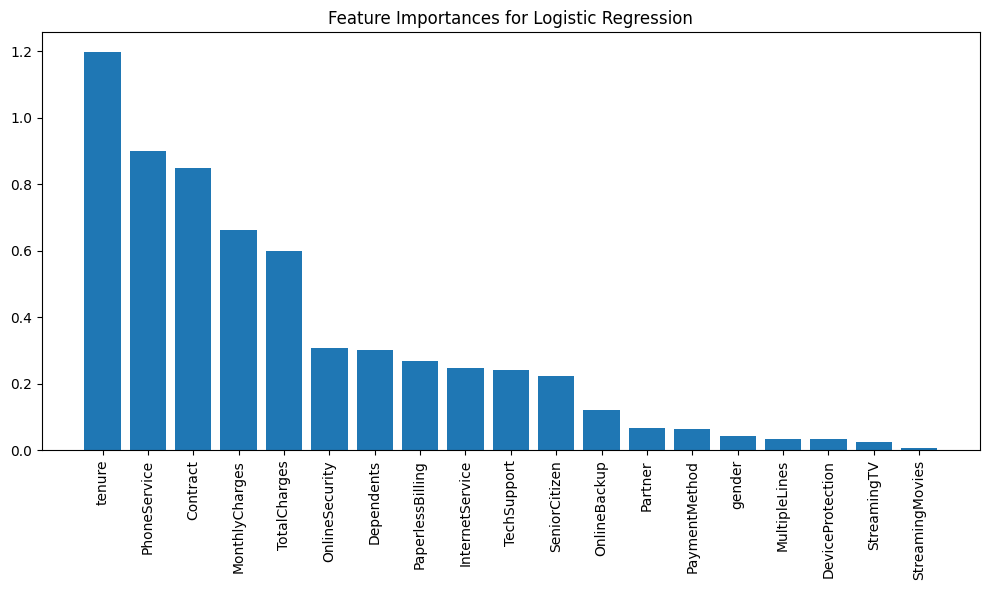

Model SVM does not support feature importances.
Model PyTorch Model does not support feature importances.


In [85]:
import numpy as np

import matplotlib.pyplot as plt

def plot_feature_importances(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Model {model_name} does not support feature importances.")
        return
    
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for {model_name}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Feature names
feature_names = X_train_downsampled.columns

# Plot feature importances for each model
plot_feature_importances(best_dt, "Decision Tree", feature_names)
plot_feature_importances(best_rf, "Random Forest", feature_names)
plot_feature_importances(best_xgb, "XGBoost", feature_names)
plot_feature_importances(best_lr, "Logistic Regression", feature_names)
plot_feature_importances(best_svm, "SVM", feature_names)
plot_feature_importances(best_pytorch_model.model, "PyTorch Model", feature_names)

In [23]:
rf = RandomForestClassifier()

rf.fit(X_train_downsampled, y_train_downsampled)


RandomForestClassifier()

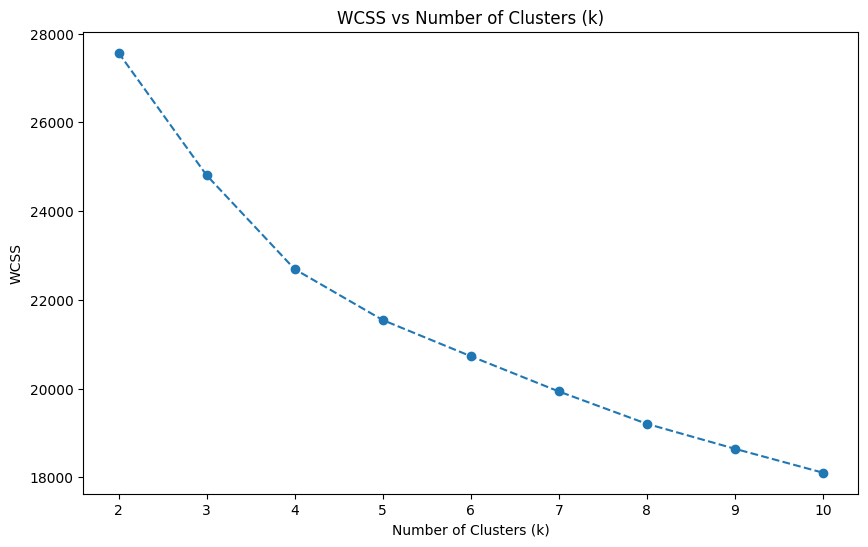

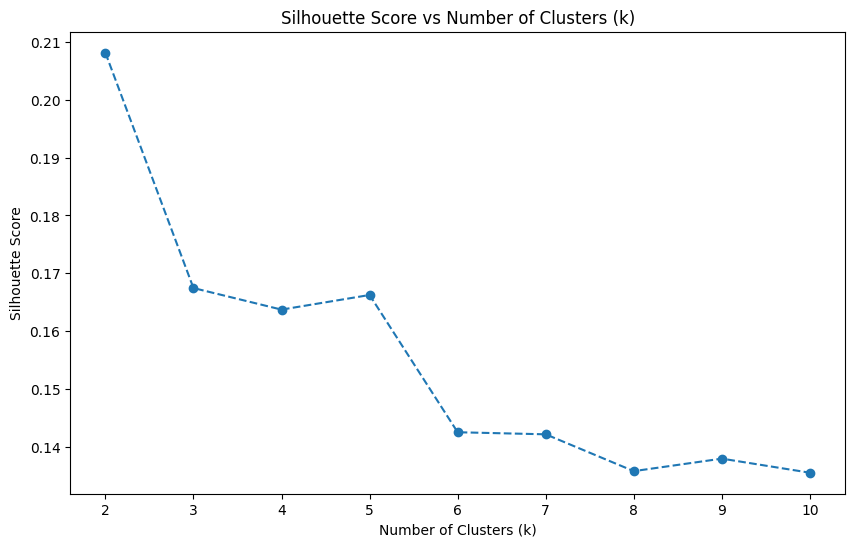

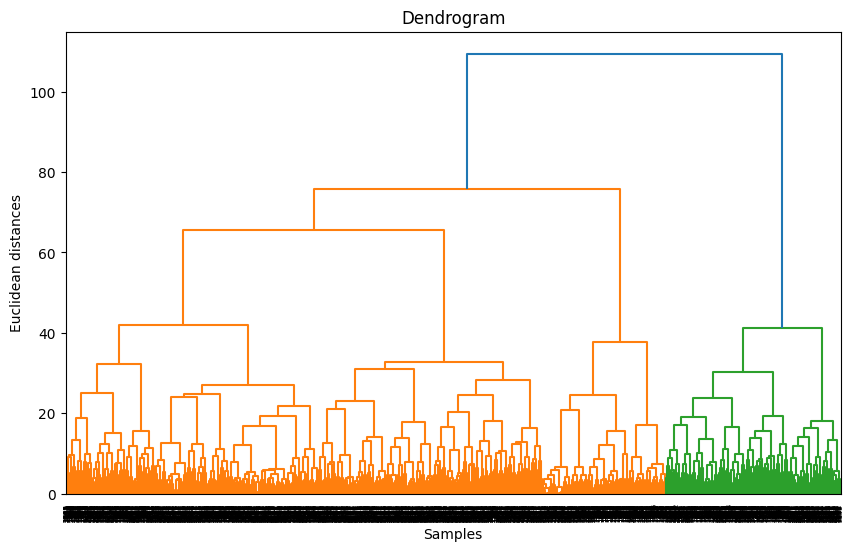

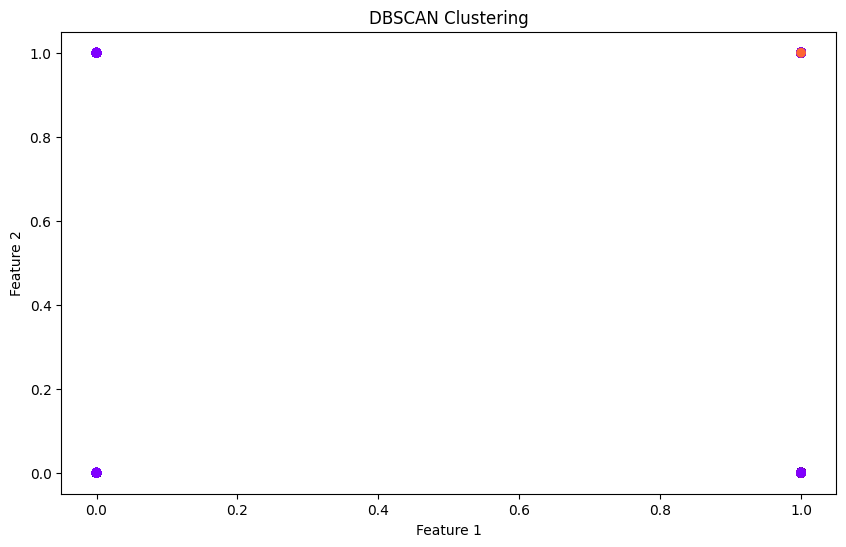

Silhouette Score for DBSCAN: -0.2345975695515545


In [69]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Perform K-means clustering
wcss = []
silhouette_scores_kmeans = []
for i in range(2, 11):  # Silhouette score is not defined for a single cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_train_downsampled)
    wcss.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(X_train_downsampled, kmeans.labels_))

# Plot WCSS vs k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), [None] + wcss, marker='o', linestyle='--')  # None for k=1
plt.title('WCSS vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Plot Silhouette Score vs k
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o', linestyle='--')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Perform hierarchical clustering
linked = linkage(X_train_downsampled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_train_downsampled)

# Calculate silhouette score for DBSCAN
silhouette_score_dbscan = silhouette_score(X_train_downsampled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Plot DBSCAN clustering results
plt.figure(figsize=(10, 6))
plt.scatter(X_train_downsampled.iloc[:, 0], X_train_downsampled.iloc[:, 1], c=dbscan_labels, cmap='rainbow')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

print(f"Silhouette Score for DBSCAN: {silhouette_score_dbscan}")

In [29]:
f1_score(y_train_downsampled, rf.predict(X_train_downsampled))

0.9983283182881979

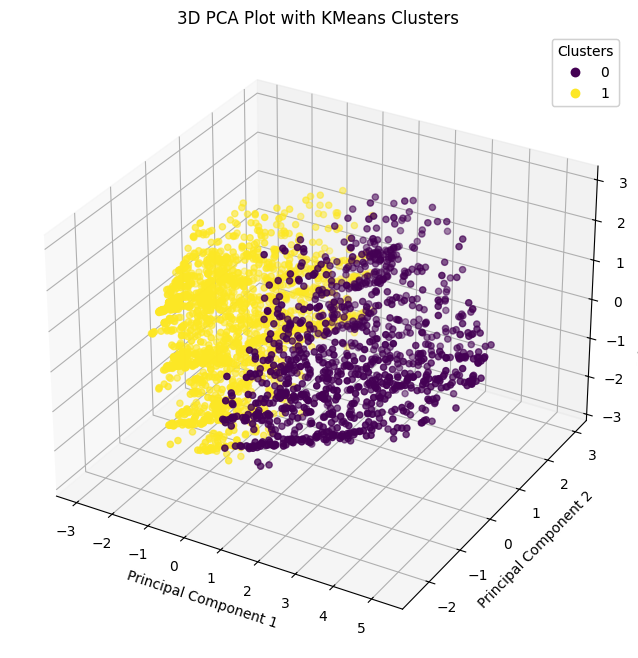

In [71]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Fit KMeans with 4 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init='auto', init='k-means++')
kmeans_2_labels = kmeans_2.fit_predict(X_train_downsampled)

# Fit PCA with 3 components
pca_3 = PCA(n_components=3)
X_train_pca_3 = pca_3.fit_transform(X_train_downsampled)

# Plot the data in 3D with the principal components as the axes and the cluster labels as the color
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca_3[:, 0], X_train_pca_3[:, 1], X_train_pca_3[:, 2], c=kmeans_2_labels, cmap='viridis')

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Plot with KMeans Clusters')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()
import plotly.express as px

# Create a DataFrame for the PCA components and cluster labels
pca_df = pd.DataFrame(X_train_pca_3, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = kmeans_2_labels

# Create an interactive 3D plot with reduced marker size
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', title='3D PCA Plot with KMeans Clusters')
fig.update_traces(marker=dict(size=3))  # Reduce marker size
fig.show()

In [72]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for the KMeans clusters
silhouette_avg = silhouette_score(X_train_downsampled, kmeans_2_labels)
print(f"Silhouette Score for KMeans clusters: {silhouette_avg}")

Silhouette Score for KMeans clusters: 0.20781698807701054


In [74]:
f1_scorer_binary = make_scorer(f1_score, average='binary', pos_label=1)


In [75]:
# Add KMeans clustering labels to the training and testing data

X_train_downsampled_kmeans = X_train_downsampled.copy()
X_test_kmeans = X_test.copy()

X_train_downsampled_kmeans['Cluster'] = kmeans_2_labels
X_test_kmeans['Cluster'] = kmeans_2.predict(X_test.drop('customerID', axis=1))

# Define the parameter grid for Decision Tree
param_grid_dt_with_cluster = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'max_features': [1, 2, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree classifier
dt_with_cluster = DecisionTreeClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search_dt_with_cluster = GridSearchCV(estimator=dt_with_cluster, param_grid=param_grid_dt_with_cluster, scoring=f1_scorer_binary, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_dt_with_cluster.fit(X_train_downsampled_kmeans, y_train_downsampled)

# Get the best estimator
best_dt_with_cluster = grid_search_dt_with_cluster.best_estimator_

# Predict on the test set
y_pred_with_cluster = best_dt_with_cluster.predict(X_test_kmeans.drop('customerID', axis=1))

# Calculate the F1 score
f1_with_cluster = f1_score(y_test, y_pred_with_cluster, average='binary', pos_label=1)

print(f"Best parameters found: {grid_search_dt_with_cluster.best_params_}")
print(f"F1 score on test set: {f1_with_cluster}")

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
F1 score on test set: 0.5667686034658511


In [78]:
from sklearn.metrics import classification_report



# Predict on the test set
y_pred_dt_with_cluster = best_dt_with_cluster.predict(X_test_kmeans.drop('customerID', axis=1))

# Print the classification report
print(classification_report(y_test, y_pred_dt_with_cluster))

              precision    recall  f1-score   support

           0       0.88      0.68      0.77      1033
           1       0.46      0.74      0.57       374

    accuracy                           0.70      1407
   macro avg       0.67      0.71      0.67      1407
weighted avg       0.77      0.70      0.71      1407

